# Выбор локации для скважины

Исследлование для добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

**Цель исследования:**  

1. Проанализировать и обработать предложенные данные по трем регионам
2. Исследовать результаты обучения модели по данным
3. Расчитать достаточные условия для прибыльности мероприятия
4. Оценить прибыльность и риски для трех предложенных регионов
5. На основе проделанной работы предложить Компании регион с максимальной суммарной прибылью отобранных скважин

**Дополнительные условия:**
 - Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
 - При разведке региона исследуют **500 точек**, из которых с помощью машинного обучения выбирают **200 лучших** для разработки.
 - Бюджет на разработку скважин в регионе — **10 млрд рублей**.
 - При нынешних ценах один баррель сырья приносит **450 рублей** дохода. Доход с каждой единицы продукта составляет **450 тыс. рублей**, поскольку объём указан в тысячах баррелей.
 - После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше **2.5%**. Среди них выбирают регион с наибольшей средней прибылью.

**Ход исследования**

Данные регионах в файлах "geo_data_0.csv", "geo_data_1.csv", "geo_data_2.csv". О качестве данных ничего не известно. Поэтому перед тем, как приступать к целям исследования, понадобится обзор данных

Я проверю данные на ошибки и оценю их влияние на исследование. Затем, на этапе предобработки я поищу возможность исправить все ошибки данных, которые не приведут к искажению конечного результата. Далее, создам необходимое количество дополнительных колонок и таблиц, приступлю к проведению анализа

Анализ в свою очередь пройдет в три этапа:

1. Обучение модели для каждого региона
2. Расчет достаточного объёма сырья для безубыточной разработки нового региона
2. Расчет рисков и прибыли для каждого региона

Завершающий этап -- выбор наиболее подходящего региона из трёх предложенных

Таким образом, моё исследование пройдёт в восемь этапов:

1. Обзор данных
2. Предобработка данных
3. Подготовка данных к обучению модели
4. Обучение и проверка модели для каждого региона
5. Подготовка к расчёту прибыли
6. Расчёт прибыли и рисков
7. Выбор региона
8. Общий вывод

**Описание данных:**
* **Признаки:**  
    - **id** — уникальный идентификатор скважины  
    - **f0, f1, f2** — три признака точек (неважно, что они означают, но сами признаки значимы)  
* **Целевой признак:**
    - **product** — объём запасов в скважине (тыс. баррелей)  

Для начала импортируем библиотеки и зафиксируем глобальные константы:

In [1]:
import pandas as pd
import numpy as np
import warnings
from math import ceil

import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

from sklearn.linear_model import LinearRegression 

from sklearn.metrics import mean_squared_error

In [2]:
# Общие константы:

RAND_FIX = 12345 # Зафиксируем random_state

In [3]:
warnings.filterwarnings('ignore') # отключаем предупреждения

## Шаг 1 Подготовка данных

### 1.1 Открытие и изучение данные

In [4]:
try:
    d_field_0 = pd.read_csv('datasets/geo_data_0.csv', sep=',') # загружаем с локального хранилища
    d_field_1 = pd.read_csv('datasets/geo_data_1.csv', sep=',')
    d_field_2 = pd.read_csv('datasets/geo_data_2.csv', sep=',')
    
    print('*' * 50, 'Месторождение "Ноль"', sep='\n')
    display(d_field_0.head(5))
    print()
    d_field_0.info()
    print('*' * 50, 'Месторождение "Один"', sep='\n')
    display(d_field_1.head(5))
    print()
    d_field_1.info()
    print('*' * 50, 'Месторождение "Два"', sep='\n')
    display(d_field_2.head(5))
    print()
    d_field_2.info()
except:
    d_field_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv', sep=',') # если что-то не выходит, то с Яндекса
    d_field_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv', sep=',')
    d_field_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv', sep=',')
    
    print('Файл загружен из хранилища Яндекс')
    print('*' * 50, 'Месторождение "Ноль"', sep='\n')
    display(d_field_0.head(5))
    print()
    d_field_0.info()
    print('*' * 50, 'Месторождение "Один"', sep='\n')
    display(d_field_1.head(5))
    print()
    d_field_1.info()
    print('*' * 50, 'Месторождение "Два"', sep='\n')
    display(d_field_2.head(5))
    print()
    d_field_2.info()

**************************************************
Месторождение "Ноль"


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
**************************************************
Месторождение "Один"


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
**************************************************
Месторождение "Два"


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


1. Названия колонок -- ОК
2. Пропусков нет
3. Типы данных -- ОК
4. ID скважин нужно будет удалить после проверки на дубликаты
5. Все необходимые для обучения данные численные

Посмотрим на распределение признаков для того, чтоб решить, нужно ли проводить масштабирование данных:

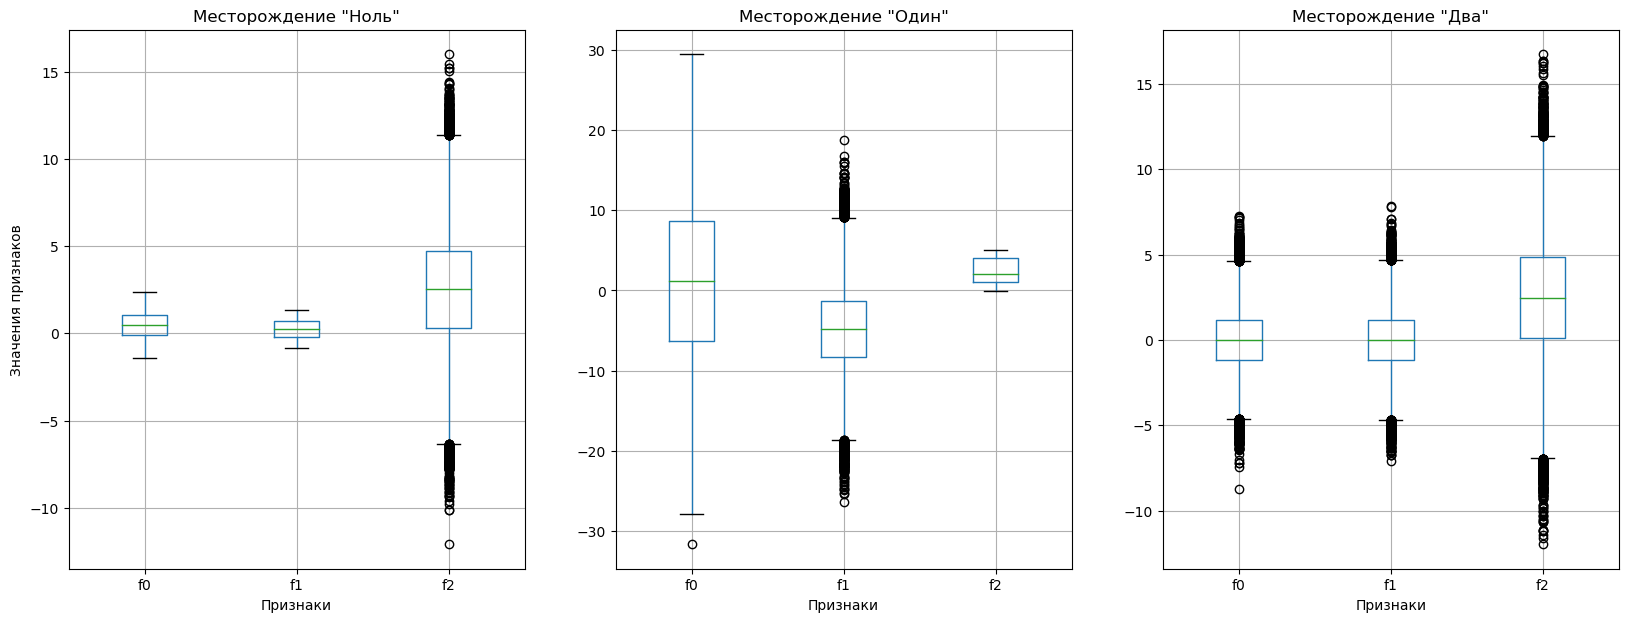

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))

d_field_0[['f0', 'f1', 'f2']].boxplot(ax=axes[0])
d_field_1[['f0', 'f1', 'f2']].boxplot(ax=axes[1])
d_field_2[['f0', 'f1', 'f2']].boxplot(ax=axes[2])
axes[0].set_title('Месторождение "Ноль"')
axes[1].set_title('Месторождение "Один"')
axes[2].set_title('Месторождение "Два"')
axes[0].set_ylabel('Значения признаков')
axes[0].set_xlabel('Признаки')
axes[1].set_xlabel('Признаки')
axes[2].set_xlabel('Признаки');

Судя по графикам, масштабтрование полезно провести будет.

**NB!** Обратим внимание, что распределение значений признаков для региона "Один" заметно отличается от регионов "Ноль" и "Два".

Посмотрим на распределние целевого показателя:

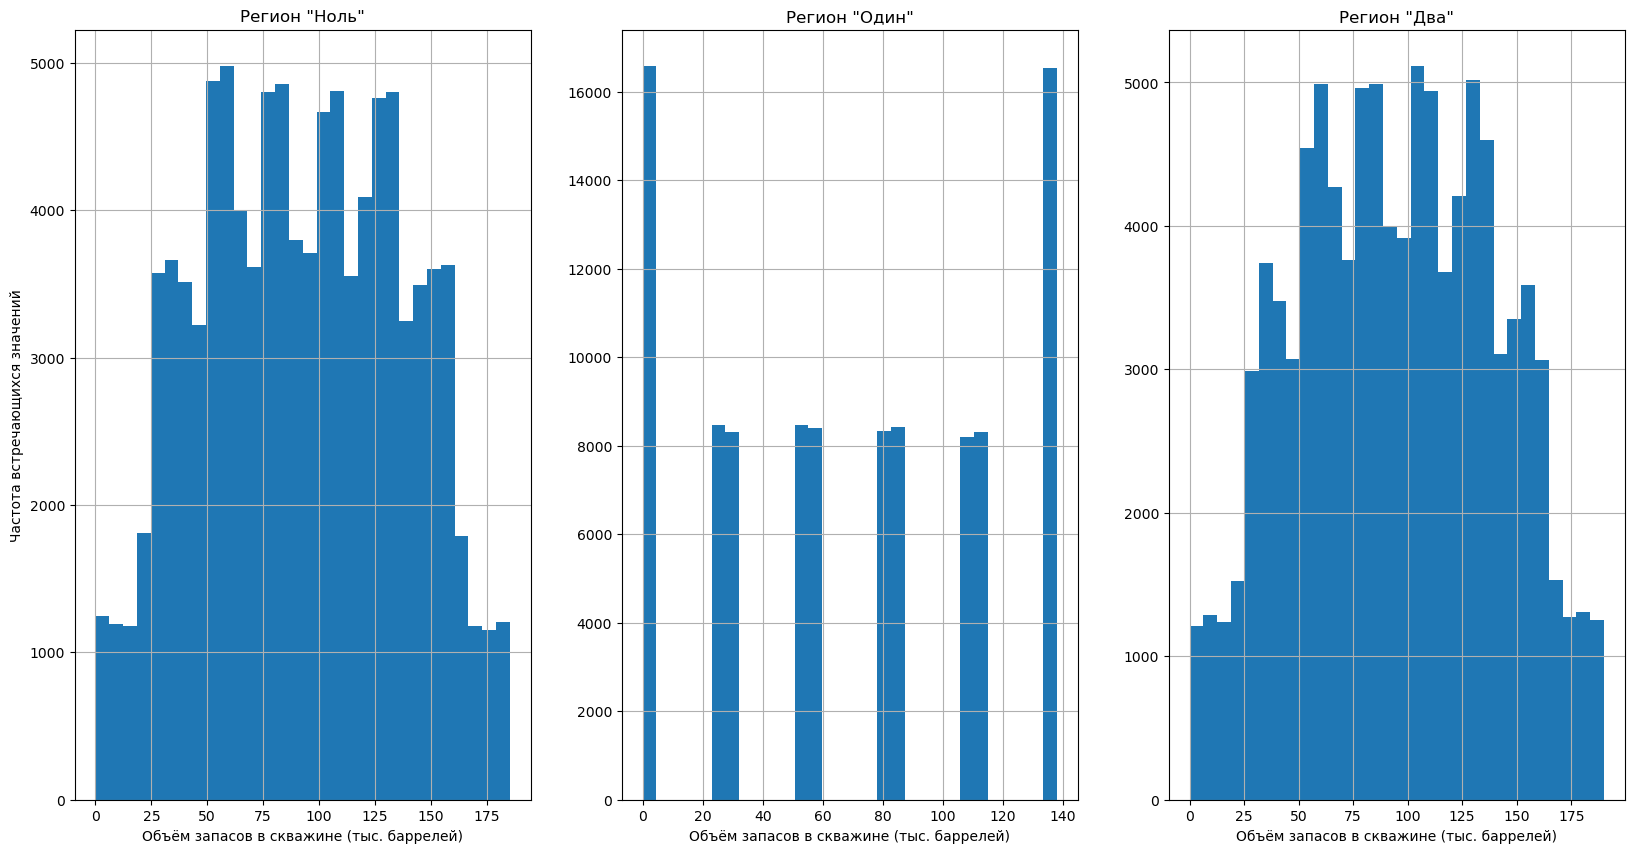

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))

d_field_0['product'].hist(ax=axes[0], bins=30)
d_field_1['product'].hist(ax=axes[1], bins=30)
d_field_2['product'].hist(ax=axes[2], bins=30)
axes[0].set_title('Регион "Ноль"')
axes[1].set_title('Регион "Один"')
axes[2].set_title('Регион "Два"')
axes[0].set_ylabel('Частота встречающихся значений')
axes[0].set_xlabel('Объём запасов в скважине (тыс. баррелей)')
axes[1].set_xlabel('Объём запасов в скважине (тыс. баррелей)')
axes[2].set_xlabel('Объём запасов в скважине (тыс. баррелей)');

С регионом "Один" опять странности.
Посмотрим, что на краях:

In [7]:
d_field_1.loc[d_field_1['product'] == 0, 'product'].count() / d_field_1.shape[0] * 100

8.235000000000001

In [8]:
d_field_1.loc[d_field_1['product'] == d_field_1['product'].max(), 'product'].count() / d_field_1.shape[0] * 100

8.233

Интересно. 8.2 процента пустых скважин, 8.2 процента скважин с максимальной заполненностью, причем значения максимума совападают.
Посмотрим еще более детально на значения целевого показателя:

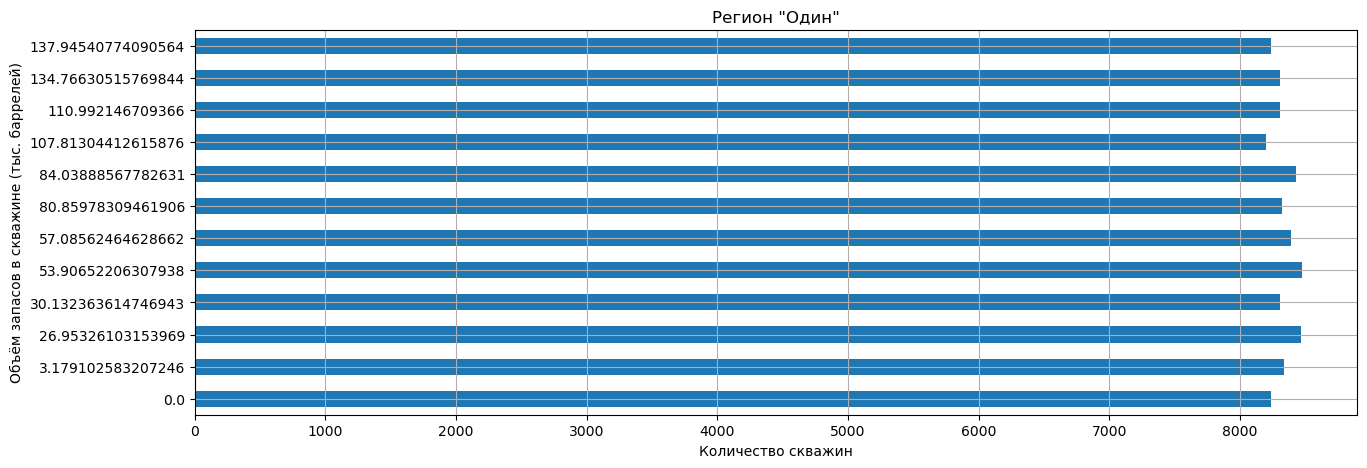

In [9]:
axes = d_field_1.groupby('product')['product'].count().plot(kind='barh', grid=True, figsize=(15, 5))
axes.set_title('Регион "Один"')
axes.set_ylabel('Объём запасов в скважине (тыс. баррелей)')
axes.set_xlabel('Количество скважин');

Очень странный регион.  
На сто тысяч скважин взяли одиннадцать вариантов объема запасов нефти (плюс ноль), причем на каждое значение приходится от 8 200 до 8 500 скважин.  
Не эксперт в нефредобыче, но даже поверхностное исследование по региону "Один" наводит на мысли о каком-то уж слишком синтетическом генезисе данных.  
Я понимаю, что в условии задачи было сказано про синтетику, но это перебор, кмк.
На мой взгляд, правильнее было бы сразу исключить регион "Один" из исследования, но так как у нас дальше будут разработаны универсальные функции, то не вижу проблем посмотреть, к каким выводам мы придем на таких удивительных данных.  

Осталось проверить на утечку целевого признака:

In [10]:
d_field_0.drop('id', axis=1).corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [11]:
d_field_1.drop('id', axis=1).corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [12]:
d_field_2.drop('id', axis=1).corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Сильная зависимость наблюдается в регионе "Один" между f2 и product (к-т 0.999397), в регионах "Ноль" и "Два" -- средне-слабая зависимость (к-ты 0.483663 и 0.445871 соответственно).  
К сожалению, мы ничего не знаем про то, что именно хранится в fi-тых значнеиях, поэтому удалять что-либо не будем, так как не можем интерпретировать должным образом результаты.  
Но сразу предположим, что модель для региона "Один" будет ну очень хорошо обучаться.

Выводы по обзору данных:
1. Трогать не будем:
    * Типы данных
    * Нзвания колонок
    * Пропуски данных
2. На предобработку:
    * Проверка на дубликаты
    * Удаление столбца ID
    * Выделение обучающей и валидационной выборок
    * Масштабирование признаков

Также на этапе обзора данных обнаружили странности в данных по региону "Один".

### 1.2 Предобработка

#### 1.2.1 Проверка на дубликаты
Проверим, есть ли полные дубликаты и дубли скважин по id

In [13]:
print('Количество полных дубликатов "Ноль":', d_field_0.duplicated().sum())
print('Количество полных дубликатов "Один":', d_field_1.duplicated().sum())
print('Количество полных дубликатов "Два":', d_field_2.duplicated().sum())

Количество полных дубликатов "Ноль": 0
Количество полных дубликатов "Один": 0
Количество полных дубликатов "Два": 0


Полных дублей нет, проверим, что по ID:

In [14]:
print('\n', '*' * 50, 'Дубликаты по id скважины для региона "Ноль":', sep='\n')
display(d_field_0.loc[d_field_0.duplicated(subset='id', keep=False), :].sort_values('id'))
print('\n', '*' * 50, 'Дубликаты по id скважины для региона "Один":', sep='\n')
display(d_field_1.loc[d_field_1.duplicated(subset='id', keep=False), :].sort_values('id'))
print('\n', '*' * 50, 'Дубликаты по id скважины для региона "Два":', sep='\n')
display(d_field_2.loc[d_field_2.duplicated(subset='id', keep=False), :].sort_values('id'))



**************************************************
Дубликаты по id скважины для региона "Ноль":


,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502




**************************************************
Дубликаты по id скважины для региона "Один":


,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305




**************************************************
Дубликаты по id скважины для региона "Два":


,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


Странно -- дубли по id скважин есть, но:
1. Их изчезающе мало -- не более десяти пар на регион при ста тысячах строк
2. fi-тые и целевой показатель у совпадающих id различны

Какие-то закономерности найти не удалось, значения в пределах распределения, поэтому:
1. Столбец id сносим
2. Строчки-дубли не сносим

В остальном процедура подготовки данных у нас единообразно проходить будет:
1. Дропаем столбец id
2. Выделим обучающую и валидационную выборки в соотношении 75:25
3. Масштабируем данные

In [15]:
def datenaufbereitung (data):

# Дропаем id:
    data = data.drop('id', axis=1)
    
# Выделяем целевой показатель:
    target = data['product']
    features = data.drop('product', axis=1)
    
# Выделяем тренировочную и валидационную выборки:
    features_train, features_valid, target_train, target_valid =\
    train_test_split(features, target, test_size=0.25, random_state=RAND_FIX)
    
    print('features_train:', features_train.shape, ' target_train:', target_train.shape)
    print('features_valid:', features_valid.shape, ' target_valid:', target_valid.shape, '\n')

# Проводим масштабирование:
    numeric = ['f0', 'f1', 'f2']
    scaler = StandardScaler()
    scaler.fit(features_train.loc[:, numeric])
    features_train.loc[:, numeric] = scaler.transform(features_train.loc[:, numeric])
    features_valid.loc[:, numeric] = scaler.transform(features_valid.loc[:, numeric])
    
# Визуализация результатов
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

    features_train.boxplot(ax=axes[0])
    target_train.hist(ax=axes[1], bins=30)
    features_valid.boxplot(ax=axes[2])
    target_valid.hist(ax=axes[3], bins=30)
    
    axes[0].set_title('features_train')
    axes[1].set_title('target_train')
    axes[2].set_title('features_valid')
    axes[3].set_title('target_valid')
    axes[0].set_ylabel('Значения признаков')
    axes[1].set_ylabel('Частота встречающихся значений')
    axes[2].set_ylabel('Значения признаков')
    axes[3].set_ylabel('Частота встречающихся значений')
    axes[0].set_xlabel('Признаки')
    axes[1].set_xlabel('Объём запасов в скважине (тыс. баррелей)')
    axes[2].set_xlabel('Признаки')
    axes[3].set_xlabel('Объём запасов в скважине (тыс. баррелей)')
    
    return features_train.reset_index(drop=True), features_valid.reset_index(drop=True), \
target_train.reset_index(drop=True), target_valid.reset_index(drop=True)

#### 1.2.1 Подготовка данных к обучению модели



**************************************************
Подготовка к обучению для региона "Ноль":


features_train: (75000, 3)  target_train: (75000,)
features_valid: (25000, 3)  target_valid: (25000,) 



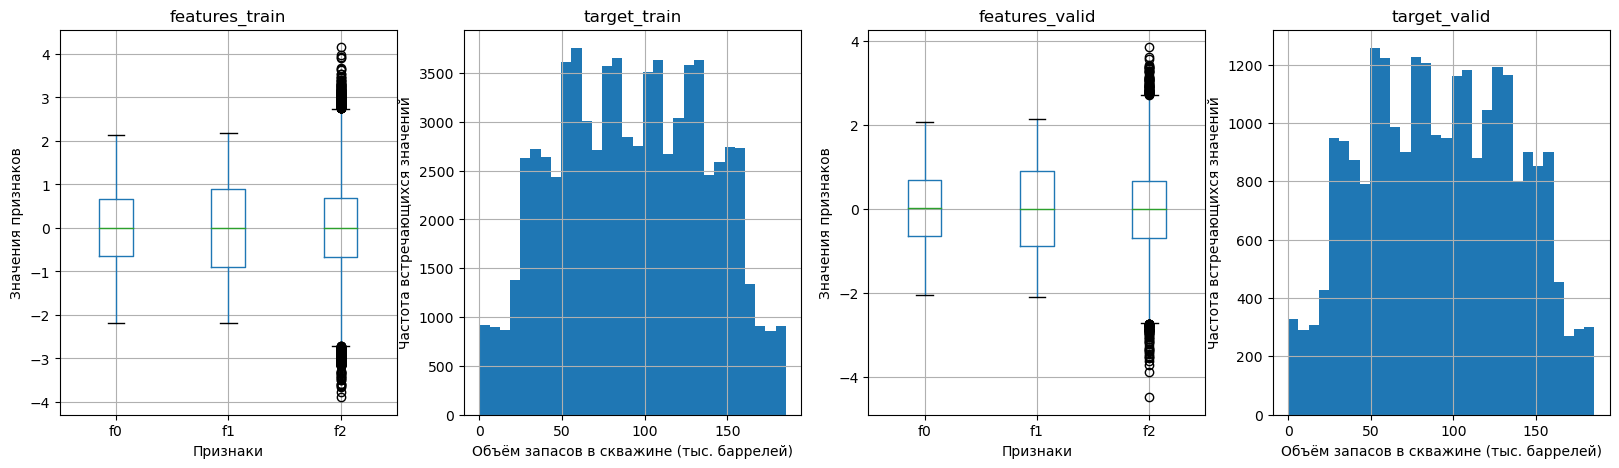

In [16]:
print('\n', '*' * 50, 'Подготовка к обучению для региона "Ноль":', '\n', sep='\n')
features_train_0, features_valid_0, target_train_0, target_valid_0 = datenaufbereitung(d_field_0)



**************************************************
Подготовка к обучению для региона "Один":


features_train: (75000, 3)  target_train: (75000,)
features_valid: (25000, 3)  target_valid: (25000,) 



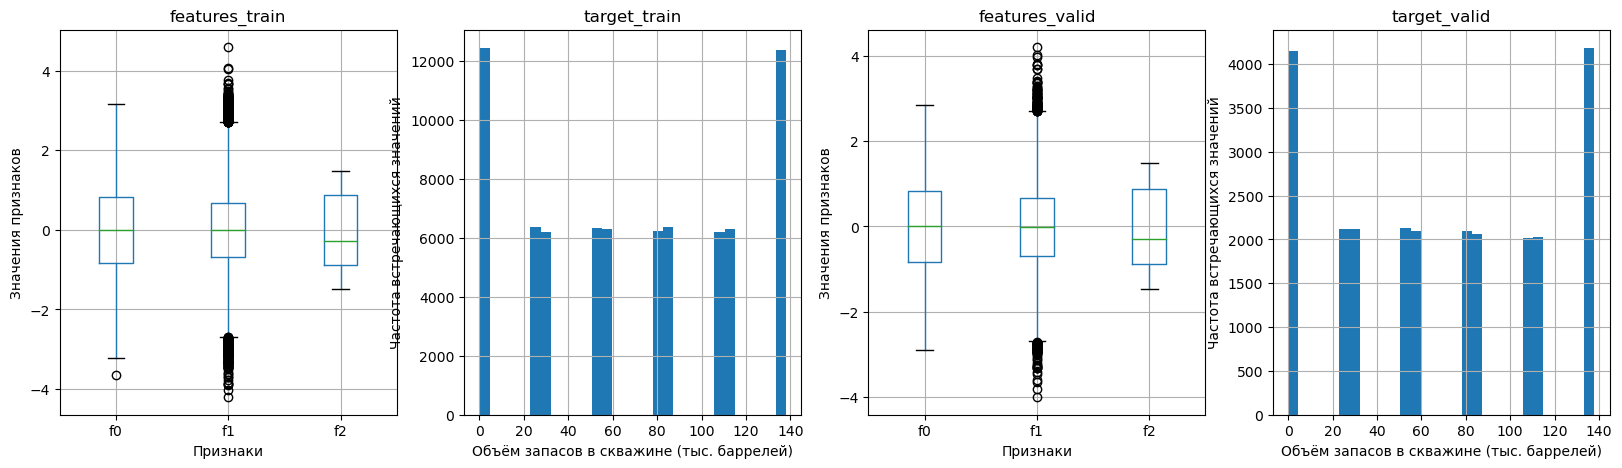

In [17]:
print('\n', '*' * 50, 'Подготовка к обучению для региона "Один":', '\n', sep='\n')
features_train_1, features_valid_1, target_train_1, target_valid_1 = datenaufbereitung(d_field_1)



**************************************************
Подготовка к обучению для региона "Два":


features_train: (75000, 3)  target_train: (75000,)
features_valid: (25000, 3)  target_valid: (25000,) 



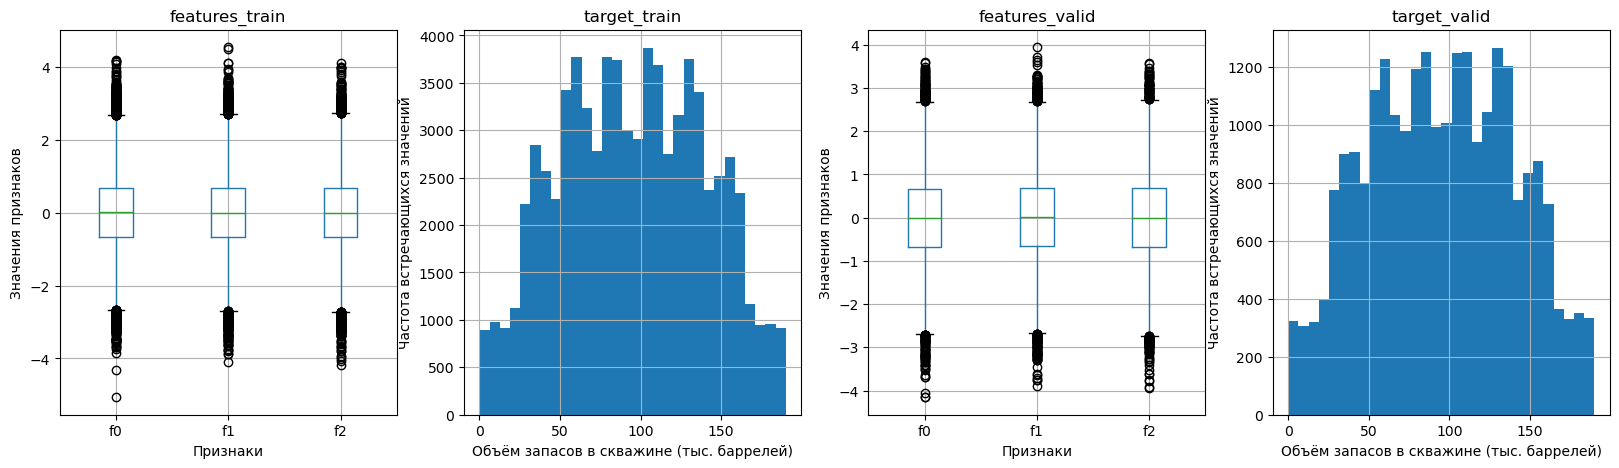

In [18]:
print('\n', '*' * 50, 'Подготовка к обучению для региона "Два":', '\n', sep='\n')
features_train_2, features_valid_2, target_train_2, target_valid_2 = datenaufbereitung(d_field_2)

Распределение на взгляд корректное, приступим к обучению.

## Шаг 2 Обучение и проверка модели для каждого региона

По условию исследования обучим LinearRegression() и посчитаем:
1. RMSE модели 
2. Средний предсказанный объем запаса нефти в скважине для каждого региона

Определим функцию **training**, которая возвращает эти значения плюс предсказанные значения для валидационной выборки:

In [19]:
def training (features_train, features_valid, target_train, target_valid):
    model = LinearRegression()
    model.fit(features_train,target_train)
    predicted_valid = model.predict(features_valid)
    mean = predicted_valid.mean()
    rmse = mean_squared_error(predicted_valid, target_valid) ** 0.5
    print('RMSE =', round(rmse, 2))
    print('Средний предсказанный запас в скважине:', round(mean, 2), 'тысяч баррелей')
    print('Средний действительный запас в скважине:', round(target_valid.mean(), 2), 'тысяч баррелей')
    
    return pd.Series(predicted_valid), mean, rmse

In [20]:
predicted_valid_0, mean_0, rmse_0 = training(features_train_0, features_valid_0, target_train_0, target_valid_0)

RMSE = 37.58
Средний предсказанный запас в скважине: 92.59 тысяч баррелей
Средний действительный запас в скважине: 92.08 тысяч баррелей


In [21]:
predicted_valid_1, mean_1, rmse_1 = training(features_train_1, features_valid_1, target_train_1, target_valid_1)

RMSE = 0.89
Средний предсказанный запас в скважине: 68.73 тысяч баррелей
Средний действительный запас в скважине: 68.72 тысяч баррелей


In [22]:
predicted_valid_2, mean_2, rmse_2 = training(features_train_2, features_valid_2, target_train_2, target_valid_2)

RMSE = 40.03
Средний предсказанный запас в скважине: 94.97 тысяч баррелей
Средний действительный запас в скважине: 94.88 тысяч баррелей


По результатам обучения:
1. Луший результат в части значения RMSE модели у региона "Один" (**0.89**), причем лучше примерно на два порядка, чем у регионов "Ноль" и "Два" (**37.58** и **40.03** соответственно)
2. Лучший средний предсказанный запас у региона "Два" (**94.97 тысяч баррелей**) против **92.59 тысяч баррелей** и **68.73 тысяч баррелей** у регионов "Ноль" и "Один" соответственно  

Визуализируем это:

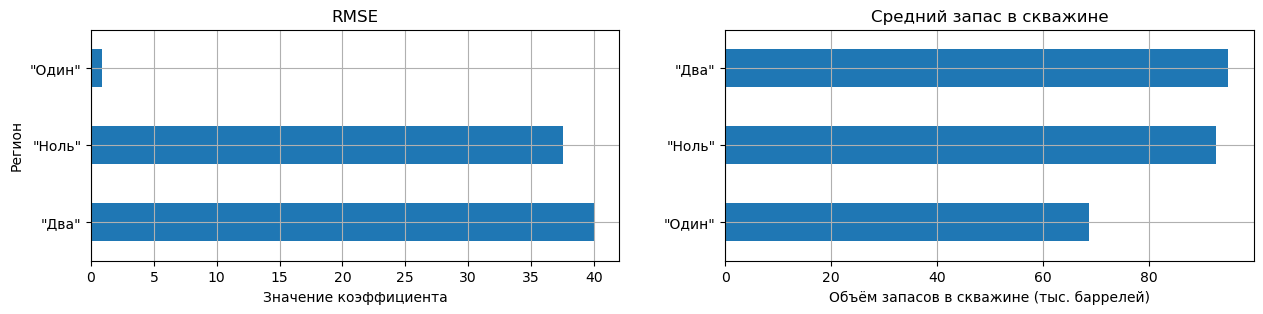

In [23]:
d_res = {'RMSE':[rmse_0, rmse_1, rmse_2],\
         'Средний запас в скважине':[mean_0, mean_1, mean_2]}
data_res = pd.DataFrame(index=['"Ноль"', '"Один"', '"Два"'], data=d_res)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
data_res['RMSE'].sort_values(ascending=False).plot(kind='barh', ax=axes[0], grid=True)
data_res['Средний запас в скважине'].sort_values().plot(kind='barh', ax=axes[1], grid=True)
axes[0].set_title('RMSE')
axes[1].set_title('Средний запас в скважине')
axes[0].set_ylabel('Регион')
axes[0].set_xlabel('Значение коэффициента')
axes[1].set_xlabel('Объём запасов в скважине (тыс. баррелей)');

## Шаг 3 Подготовка к расчёту прибыли

Зафиксируем бизнесовые параметры для расчета прибыли:

In [24]:
# Константы для расчета прибыли и рисков

BUDGET_FOR_DEVELOPMENT = 10 ** 10 # Бюджет на разработку скважин в регионе — BUDGET_FOR_DEVELOPMENT рублей
INCOME_PER_THOUSAND_BARRELS = 450_000 # Доход с каждой единицы продукта составляет INCOME_PER_THOUSAND_BARRELS рублей
RESEARCH_BOREHOLES_CNT = 500 # При разведке региона исследуют RESEARCH_BOREHOLES_CNT точек
BEST_BOREHOLES_CNT = 200 # из RESEARCH_BOREHOLES_CNT точек выбирают BEST_BOREHOLES_CNT лучших для разработки
DAMAGE_PROBABILITY_LIMIT = 0.025 # Нужно оставить лишь те регионы, в которых вероятность убытков меньше DAMAGE_PROBABILITY_LIMIT

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.  
На разработку бюджет десять миллиардов рублей, разделим его на количество скважин, которые предполагается осваивать (200), получим бюджет на скважину.  
После разделим бюджет на скважину на доход с тысячи баррелей (450 тыс. рублей), получим нижнюю границу достаточных запасов в скважине, чтоб отбить затраты:  

In [25]:
suff_amount = (BUDGET_FOR_DEVELOPMENT / BEST_BOREHOLES_CNT) / INCOME_PER_THOUSAND_BARRELS
suff_amount

111.11111111111111

Чтоб скважина была прибыльной ее объем должен привышать 111.(1) тысяч баррелей.  
Сравним со средним по региону:

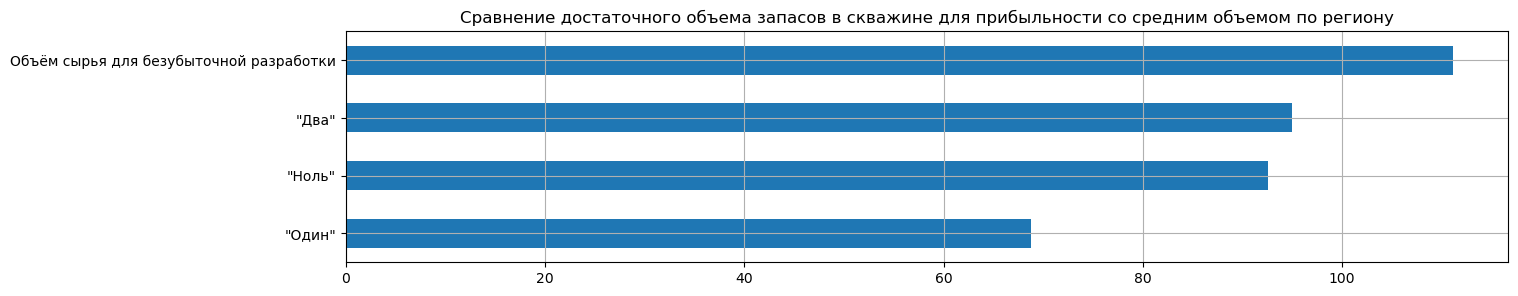

In [26]:
pd.concat([pd.DataFrame(index=['Объём сырья для безубыточной разработки'], \
                        data={'RMSE':np.nan, 'Средний запас в скважине':suff_amount}), data_res])\
.loc[:, 'Средний запас в скважине'].sort_values().\
plot(kind='barh', figsize=(15, 3), grid=True, \
     title='Сравнение достаточного объема запасов в скважине для прибыльности со средним объемом по региону');

Видим, что если мы будем брать в работу скважины вслепую, то прогорим почти наверняка -- среднее по региону нигде не превышает достаточного объема запасов в скважине для прибыльности.  
Поэтому определим функцию **profit**, которая бедет эмулировать процесс получения ожиданий-реальности:

1. Определим по предсказаниям BEST_BOREHOLES_CNT лучших скважин
2. Для этих скважин просуммируем реальное значение объема
3. Посчитаем по этому множеству прибыльность, то есть, умножим на прибыль с тысячи бареллей и сравним с затратами на разработку

In [27]:
def profit (predicted_valid, target_valid):
    predicted_valid = predicted_valid.reset_index(drop=True)
    target_valid = target_valid.reset_index(drop=True)
    sum_amount = target_valid.loc[predicted_valid.sort_values(ascending=False).head(BEST_BOREHOLES_CNT).index].sum()
    return sum_amount * INCOME_PER_THOUSAND_BARRELS - BUDGET_FOR_DEVELOPMENT

## Шаг 4 Расчёт прибыли и рисков 

Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли, по этому распределению зафиксировать:

1. Среднюю прибыль
2. 95-й доверительный интервал
3. Риск убытков

Для начала определим функцию **format_rub**, которая более наглядно выводила бы данные, которые касаются значений прибыли:

In [28]:
def format_rub (n):
    
    n = str(round(n))
    cnt = 0
    for i in range(3, len(n), 3):
        n = n[:-i - cnt] + ' ' + n[-i - cnt:]
        cnt +=1
    return n + ' руб.'

Определим функцию **bootstrap_and_quantile**, которая получает на вход предсказанные и истинные значения по региону и выводит:

1. Среднюю прибыль
2. 95-й доверительный интервал
3. Риск убытков

In [29]:
def bootstrap_and_quantile (predicted_valid, target_valid):
    values = []
    state = np.random.RandomState(RAND_FIX)
#     Применяем методику Bootstrap -- для тысячи вариантов вызываем функцию расчета прибыли, причем
#     в каждом случае выбираем BEST_BOREHOLES_CNT (двести) лучших скважин из RESEARCH_BOREHOLES_CNT (пятьсот) случайных
#     Результаты складываем последовательно  в values
    for _ in range(1000):
        subsample = target_valid.sample(n=RESEARCH_BOREHOLES_CNT, replace=True, random_state=state)
        values.append(profit(predicted_valid[subsample.index], subsample))
    values = pd.Series(values)
#     Считаем среднюю прибыль
    mean_profit = values.mean()
    print('Средняя прибыль:', format_rub(mean_profit))
#     95-й процентиль отрезает по два с половиной процента с краев распределения:
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    print('95-й доверительный интервал:', format_rub(lower), '--', format_rub(upper))
#     Считаем вероятность убытка -- количество результатов с "отрицательным доходом" делим на общее количество
    propability_of_fail = values.loc[values<0].count() / len(values)
    print('Вероятность убытка', f'{propability_of_fail:.2%}')
    return values

Применим метод для каждого из наших трех регионов:

In [30]:
print('\n', '*' * 70, 'Результаты расчета прибыли и рисков для региона "Ноль":', '\n', sep='\n')
values_0 = bootstrap_and_quantile(predicted_valid_0, target_valid_0)
print('\n', '*' * 70, 'Результаты расчета прибыли и рисков для региона "Один":', '\n', sep='\n')
values_1 = bootstrap_and_quantile(predicted_valid_1, target_valid_1)
print('\n', '*' * 70, 'Результаты расчета прибыли и рисков для региона "Два":', '\n', sep='\n')
values_2 = bootstrap_and_quantile(predicted_valid_2, target_valid_2)



**********************************************************************
Результаты расчета прибыли и рисков для региона "Ноль":


Средняя прибыль: 396 164 985 руб.
95-й доверительный интервал: - 111 215 546 руб. -- 909 766 942 руб.
Вероятность убытка 6.90%


**********************************************************************
Результаты расчета прибыли и рисков для региона "Один":


Средняя прибыль: 456 045 106 руб.
95-й доверительный интервал: 33 820 509 руб. -- 852 289 454 руб.
Вероятность убытка 1.50%


**********************************************************************
Результаты расчета прибыли и рисков для региона "Два":


Средняя прибыль: 404 403 867 руб.
95-й доверительный интервал: - 163 350 413 руб. -- 950 359 575 руб.
Вероятность убытка 7.60%


Наименьшая вероятность убытка у региона **"Один"** -- **1.5%**, далее идут регионы **"Ноль"** с вероятностью **6.9%** и **"Два"** со значением **7.6%**.
Регионы **"Ноль"** и **"Два"** преодолели предел в 2.5% вероятности убытка, что по условиям задачи выводит их из дальнейшего сравнения.

Так или иначе, посмотрим пристально на распределение прибыли для регионов "Ноль" и "Один":

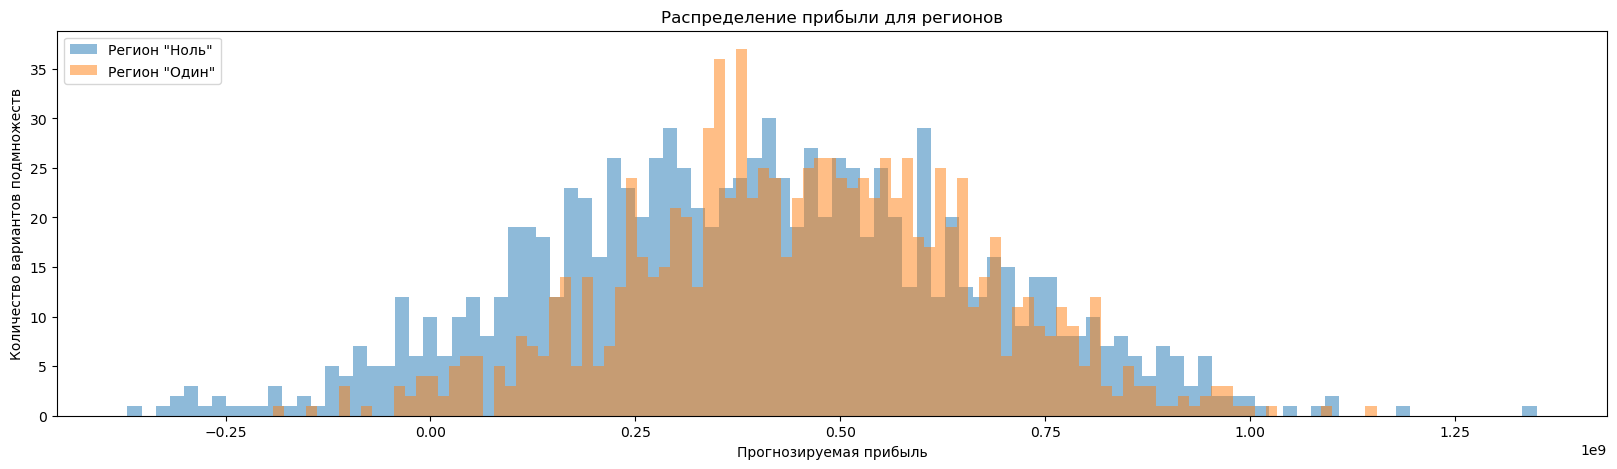

In [31]:
fig, ax = plt.subplots(figsize=(20,5))

axes = ax.hist(values_0, bins=100, label='Регион "Ноль"', alpha=0.5)
axes = ax.hist(values_1, bins=100, label='Регион "Один"', alpha=0.5)

ax.set_title('Распределение прибыли для регионов') 
ax.set_xlabel('Прогнозируемая прибыль')
ax.set_ylabel('Количество вариантов подмножеств') 
ax.legend(loc='upper left');

На графике видим, что значения прибыли для региона "Один" более кучно сконцентрированы вокруг среднего по сравнению  с регионом "Ноль".

## Общий вывод

В ходе исследования:

Получены данные о регионах в файлах "geo_data_0.csv", "geo_data_1.csv", "geo_data_2.csv". Проведен обзор данных.
Данные проверены на ошибки, и оценено их влияние на исследование. Затем предложенные данные были преобразованы. Далее, создано необходимое количество дополнительных колонок и таблиц, для того, чтоб приступить к проведению анализа.

Анализ в свою очередь прошел в три этапа:

1. Обучение модели для каждого региона
2. Расчет достаточного объёма сырья для безубыточной разработки нового региона
2. Расчет рисков и прибыли для каждого региона

Завершающий этап -- выбор наиболее подходящего региона из трёх предложенных

Таким образом, исследование состояло из следующих этапов, на каждом из которых формировались выводы, которые попали в итоги работы:

1. Обзор данных
2. Предобработка данных
3. Подготовка данных к обучению модели
4. Обучение и проверка модели для каждого региона
5. Подготовка к расчёту прибыли
6. Расчёт прибыли и рисков

### Итоги исследования:

1. **Рекомендации в части данных**  
На этапе обзора данных обнаружены странности в данных для региона "Один". Если кратко, то:
    - Объемы доступных ресурсов для стат тысяч скважин представляет из себя равномерное распределение малого количества зафиксированных значений по всему множеству скважин
    - Сильнейшая корреляция f2 и result -- к-т == 0.999397  
Подробнее в П.1.1 Исследования.  
Если подобное не было учтено до старта исследования, то рекомендую обсудить с владельцем источника данных по региону "Один" методику их формирования.
  
2. **Результаты исследования**
    * Если данные по региону "Один" признать валидными, то наиболее предпочтительный регион будет "**Один**" с параметрами:
        - RMSE модели == **0.89**
        - Средний предсказанный запас в скважине == **68.73** тысяч баррелей
        - Средний действительный запас в скважине == **68.72** тысяч баррелей
        - Средняя прибыль == **456 045 106 руб.**
        - 95-й доверительный интервал: **33 820 509 руб. -- 852 289 454 руб.**
        - Вероятность убытка == **1.5%**
        
    * Если данные по региону "Один" отвергнуть, то не останется регионов, которые бы подошли по требованию:  
    "После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%."  
    
    * Так или иначе, среди аутсайдеров наиболее предпочтительный регион будет "**Ноль**" с параметрами:
        - RMSE модели == **37.58**
        - Средний предсказанный запас в скважине == **92.59** тысяч баррелей
        - Средний действительный запас в скважине == **92.08** тысяч баррелей
        - Средняя прибыль == **396 164 985 руб.**
        - 95-й доверительный интервал: **-111 215 546 руб. -- 909 766 942 руб.**
        - Вероятность убытка == **6.9%**
        
    * Ну и регион "**Два**" имеет наибольший риск убытка с параметрами:
        - RMSE модели == **40.03**
        - Средний предсказанный запас в скважине == **94.97** тысяч баррелей
        - Средний действительный запас в скважине == **94.88** тысяч баррелей
        - Средняя прибыль == **404 403 867 руб.**
        - 95-й доверительный интервал: **-163 350 413 руб. -- 950 359 575 руб.**
        - Вероятность убытка == **7.6%**  
        
